# Spike-Driven Synaptic Plasticity

In this three-part tutorial, we will look at the learning rule presented in "Learning real-world stimuli in a neural network with spike-driven synaptic dynamics" by J. M. Brader, W. Senn, and S. Fusi. You can find the online version of the paper [here](https://www.ncbi.nlm.nih.gov/pubmed/17883345). Before we train and test a SNN for a chosen task using this rule, we will examine the behaviour of the synaptic plasticity model by trying to reproduce two figures from the paper. In this tutorial, we will reproduce Figure 1 from the paper.

## Preliminaries: Set up Weight Update model and Neuron model

Based on the model reduction presented in Section 3.3 of the paper, we derived the GeNN-equivalent of the weight update model given in the paper. You can find it in `models/synapses/fusi.py`. Below, we need to simply import the model to start using it.

In [2]:
from models.synapses.fusi import fusi_model, FUSI_PARAMS, fusi_init, fusi_post_init

In this file, `fusi_model` specifies the weight update model. `FUSI_PARAMS` is used to define all the (constant) parameters the model needs. Finally, `fusi_init` and `fusi_post_init` are used to initialize the variables that are used in `sim_code` and `post_spike_code` respectively. <br>

In this model, the synaptic weight can take two values: `Jplus` or `Jminus`. Which value it takes is determined by the value of the internal synaptic variable `X`. In `sim_code`, you can see that the value of `X` is updated when a presynaptic spike arrives, and is based on the postsynaptic depolarization `V_post` and the postsynaptic calcium variable `C`. In `post_spike_code`, `C` is incremented when a postsynaptic spike occurs. <br>

In the paper, the authors use an Integrate-and-Fire neuron model with a linear leak. You can find this neuron model in `models/neurons/integrate_fire.py`. We will import this too.

In [3]:
from models.neurons.integrate_fire import if_model, IF_PARAMS, if_init

Here, `if_model` defines the dynamics of the neuron model. `IF_PARAMS` and `if_init` are used to set up the parameters and variables in the same way as the weight update model above. Let's set up some time-related parameters we need for the simulation:

In [4]:
TIMESTEP = 1.0
PRESENT_TIMESTEPS = 1500

## Part I: Reproducing Figure 1

Figure 1 from the paper shows the stochastic nature of the weight update, where the same pairing of presynaptic and postsynaptic mean firing rates produces different dynamics for `V_post`, `C` and `X`, and consequently, also for the synaptic weight. Let's reproduce this behaviour to see how the weight update model works. <br>

In this experiment, we need two neurons: a presynaptic neuron firing at 50 Hz and a postsynaptic neurons firing at 70 Hz. We will connect these neurons with a synapse based on the `fusi_model`. In concrete terms for our GeNN simulation, this means that the presynaptic neuron needs to be a Poisson neuron with a firing rate of 50 Hz. Furhter, the postsynaptic neuron needs to be connected to a extra population of 10 neurons that stimulates the postsynaptic neuron to fire at roughly 70 Hz. <br>

To start, let's set up the initializers for the presynaptic neuron and the extra Poisson neurons:

In [5]:
presyn_params = {"rate" : 50.0}
extra_poisson_params = {"rate" : 100.0}
poisson_init = {"timeStepToSpike" : 0.0}

Now, let's build a model. We will create a presynaptic population of 1 Poisson neuron, and a postsynaptic population of 1 `if_model` neuron. To make the postsynaptic neuron spike at the desired mean firing rate, we will make the 10 extra Poisson neurons spike at 100 Hz. The weights from this extra population to the postsynaptic neuron can be hand-tuned to obtain the required postsynaptic firing rate.

In [6]:
from pygenn.genn_model import GeNNModel
from pygenn.genn_wrapper import NO_DELAY

model = GeNNModel("float", "fig1")
model.dT = TIMESTEP

presyn = model.add_neuron_population("presyn", 1, "PoissonNew", presyn_params, poisson_init)
postsyn = model.add_neuron_population("postsyn", 1, if_model, IF_PARAMS, if_init)
extra_poisson = model.add_neuron_population("extra_poisson", 10, "PoissonNew",
                                            extra_poisson_params, poisson_init)

POSTSYN_WT = 0.09

pre2post = model.add_synapse_population(
            "pre2post", "DENSE_INDIVIDUALG", NO_DELAY,
            presyn, postsyn,
            fusi_model, FUSI_PARAMS, fusi_init, {}, fusi_post_init,
            "DeltaCurr", {}, {})

extra_poisson2post = model.add_synapse_population(
            "extra_poisson2post", "DENSE_INDIVIDUALG", NO_DELAY,
            extra_poisson, postsyn,
            "StaticPulse", {}, {"g": POSTSYN_WT}, {}, {},
            "DeltaCurr", {}, {})

model.build()
model.load()

Now, let's set up a place where we can store the variables we want to plot: `C`, presynaptic spike times, `X` and postsynaptic depolarization.

In [7]:
import numpy as np

neuron_layers = [presyn, postsyn]

# initialize arrays for storing all things we want to plot
layer_spikes = [(np.empty(0), np.empty(0)) for _ in enumerate(neuron_layers)]
X = np.array([fusi_init["X"]])
postsyn_V = np.array([if_init["V"]])
C = np.array([fusi_post_init["C"]])

 Let's run our simulation.

In [8]:
while model.timestep < PRESENT_TIMESTEPS:
    model.step_time()

    # Record spikes
    for i, l in enumerate(neuron_layers):
        # Download spikes
        model.pull_current_spikes_from_device(l.name)

        # Add to data structure
        spike_times = np.ones_like(l.current_spikes) * model.t
        layer_spikes[i] = (np.hstack((layer_spikes[i][0], l.current_spikes)),
                           np.hstack((layer_spikes[i][1], spike_times)))

    # Record value of X
    model.pull_var_from_device("pre2post", "X")
    X_val = pre2post.get_var_values("X")
    X = np.concatenate((X, X_val), axis=0)

    # Record value of postsyn_V
    model.pull_var_from_device("postsyn", "V")
    V_val = postsyn.vars["V"].view
    postsyn_V = np.concatenate((postsyn_V, V_val), axis=0)

    # Record value of C
    model.pull_var_from_device("pre2post", "C")
    C_val = pre2post.post_vars["C"].view
    C = np.concatenate((C, C_val), axis=0)

And finally, let's plot the results!

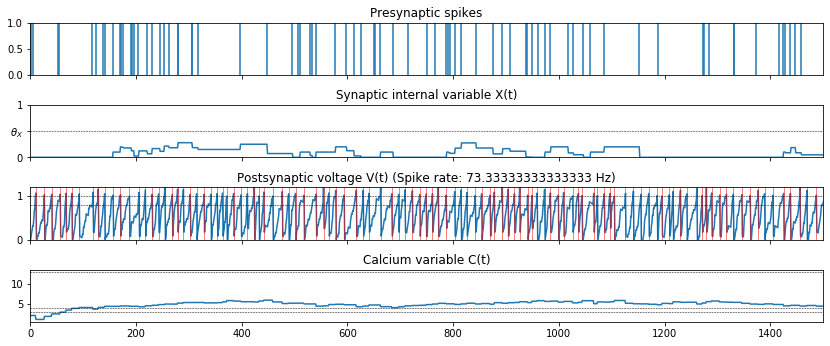

In [9]:
import matplotlib.pyplot as plt

postsyn_spike_rate = len(layer_spikes[1][1]) / (PRESENT_TIMESTEPS / 1000)

# Create plot
fig, axes = plt.subplots(4, sharex=True, figsize=(12, 5))
fig.tight_layout(pad=2.0)

# plot presyn spikes
presyn_spike_times = layer_spikes[0][1]
for s in presyn_spike_times:
    axes[0].set_xlim((0,PRESENT_TIMESTEPS))
    axes[0].axvline(s)
axes[0].title.set_text("Presynaptic spikes")

# plot X
axes[1].title.set_text("Synaptic internal variable X(t)")
axes[1].plot(X)
axes[1].set_ylim((0,1))
axes[1].axhline(0.5, linestyle="--", color="black", linewidth=0.5)
axes[1].set_yticklabels(["0", "$\\theta_X$", "1"])

# plot postsyn V
axes[2].title.set_text('Postsynaptic voltage V(t) (Spike rate: ' + str(postsyn_spike_rate) + " Hz)")
axes[2].plot(postsyn_V)
axes[2].set_ylim((0,1.2))
axes[2].axhline(1, linestyle="--", color="black", linewidth=0.5)
axes[2].axhline(0.8, linestyle="--", color="black", linewidth=0.5)
postsyn_spike_times = layer_spikes[1][1]
for s in postsyn_spike_times:
    axes[2].axvline(s, color="red", linewidth=0.5)

# plot C
axes[3].plot(C)
axes[3].title.set_text("Calcium variable C(t)")
for i in [3, 4, 13]:
    axes[3].axhline(i, linestyle="--", color="black", linewidth=0.5)

plt.show()

Above, you see a case where `X` **does not transition** from one side of &theta;<sub>X</sub> to the other. You can restart this notebook and run this simulation over and over again to see how the weight update model behaves. You can play around with the postsynaptic firing rate by changing the `POSTSYN_WT` parameter. Below, you can see a case where `X` **does transition**.

<img src="fusi_LTP.png">

When `X` starts at 0 and crosses the threshold &theta;<sub>X</sub> to the other side, it is called a Long Term Potentiation (LTP) transition. You might see in your experiments above that the frequency of LTP transitions increases as you increase the postsynaptic firing rate. In the next tutorial, we will look at the probability of LTP transition as a function of v<sub>post</sub>.